# src_10

This time I'm looking to create a [Kármán vortex street](https://en.wikipedia.org/wiki/K%C3%A1rm%C3%A1n_vortex_street). The aim is to maintain the flow speed at about $\mathcal{O}(10^{-3})~\mathrm{mm}/\mathrm{s}$, but increase significantly the Reynolds number.

New idea: I'll drive the fluid using forces again, but a smaller region of the domain (of comparable height).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
dir = '../data.lbm/10/'
# dir = '../src/10/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

print(ticks)

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550, 3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650, 4700, 4750, 4800, 4850, 4900, 4950, 5000]


# Fluido

In [16]:
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[30]}.csv").set_index(["id_x","id_y"]).sort_index()

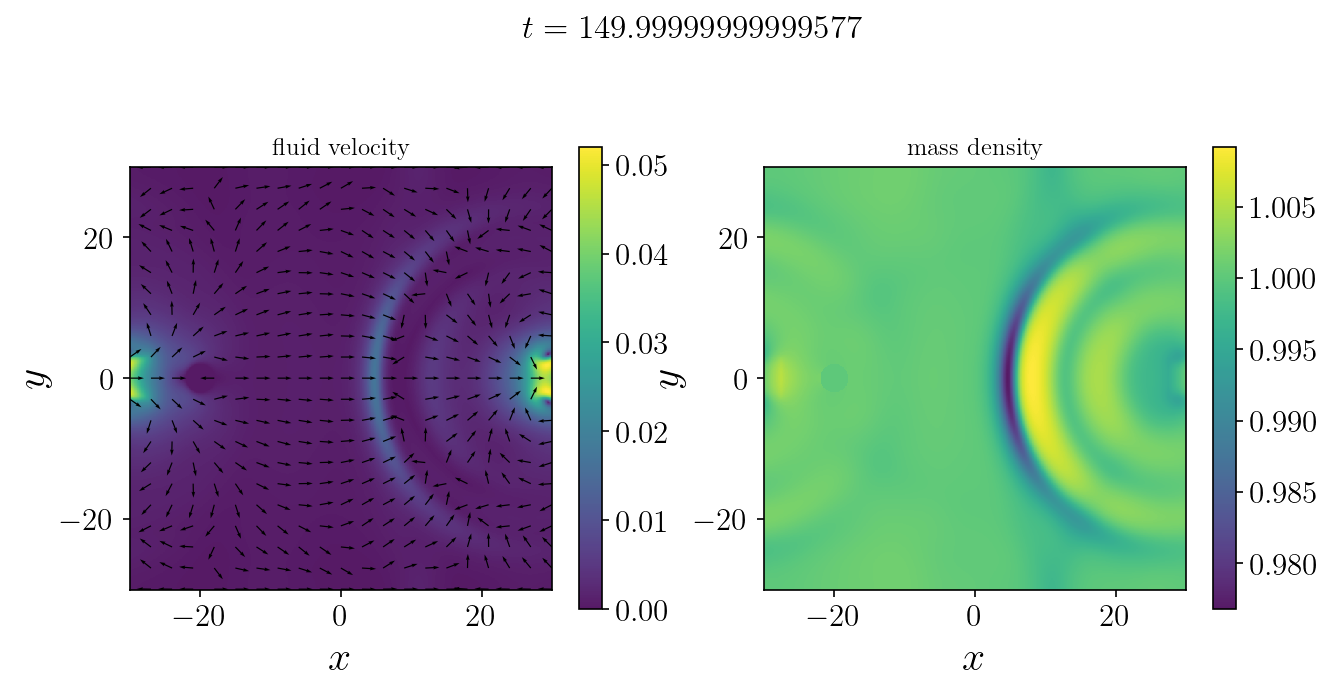

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Add a title for the whole figure
fig.suptitle(f"$t = {fluidDf.time.values[0]}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = fluidDf['coordinate_x'].unique()
y_unique = fluidDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

c = axes[0].pcolormesh(X, Y,
    np.sqrt(fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2).unstack().values.transpose(),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[0].set_title('fluid velocity')

maskStep = int(len(x_unique)/20)
# Create a mask for filtering
mask = (fluidDf['coordinate_x'].isin(x_unique[::maskStep])) & (fluidDf['coordinate_y'].isin(y_unique[::maskStep])) & (
    (fluidDf.fluidVelocity_x**2 + fluidDf.fluidVelocity_y**2 > 1e-16)
)
# Filter the DataFrame
filtered_df = fluidDf[mask]

axes[0].quiver(
    filtered_df['coordinate_x'], 
    filtered_df['coordinate_y'], 
    (filtered_df.fluidVelocity_x / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    (filtered_df.fluidVelocity_y / np.sqrt(filtered_df.fluidVelocity_x**2 + filtered_df.fluidVelocity_y**2)),
    scale = 30,
)

c = axes[1].pcolormesh(X,Y,
    fluidDf.massDensity.unstack().values.transpose(),
    vmin=min(fluidDf.query("massDensity > 0").massDensity.values),
    cmap = "viridis", alpha = 0.9
); cs.append(c);
axes[1].set_title('mass density')

for i in range(len(axes)):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary

plt.show()

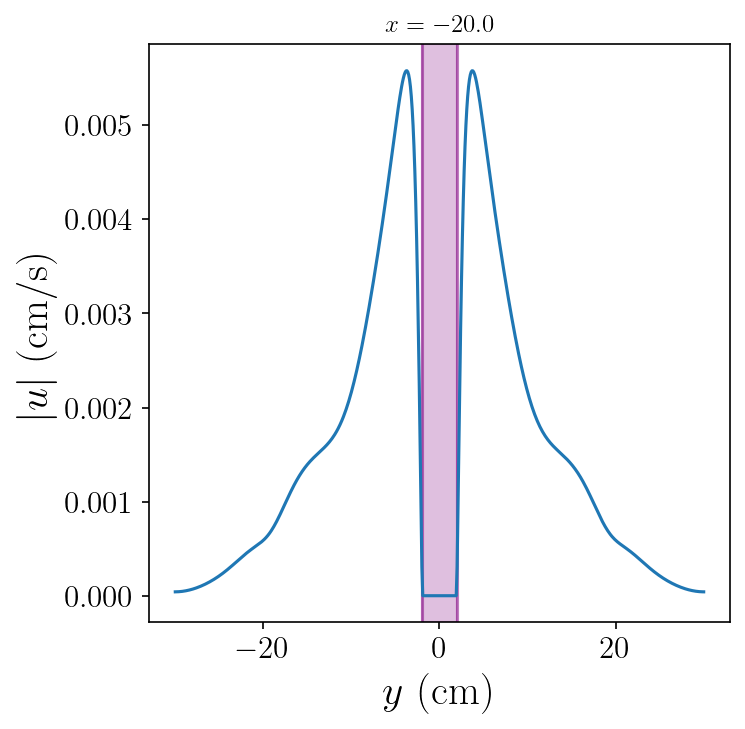

In [18]:
# v_x = fluidDf.query("coordinate_x == 15").filter(["coordinate_x","coordinate_y","fluidVelocity_x","fluidVelocity_y"])
v_x = fluidDf.query("coordinate_x == -20").filter(["coordinate_x","coordinate_y","fluidVelocity_x","fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.axvline(-2, color = "purple", alpha = 0.5)
ax.axvline(2, color = "purple", alpha = 0.5)
ax.axvspan(-2, 2, color='purple', alpha=0.25)  # Shade the wall

ax.plot(v_x.coordinate_y, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2)) 
ax.set_xlabel("$y$ (cm)")
ax.set_ylabel("$|u|$ (cm/s)")
ax.set_title(f"$x = {v_x.coordinate_x.values[0]}$")

# ax.legend(loc='upper right')

plt.show()

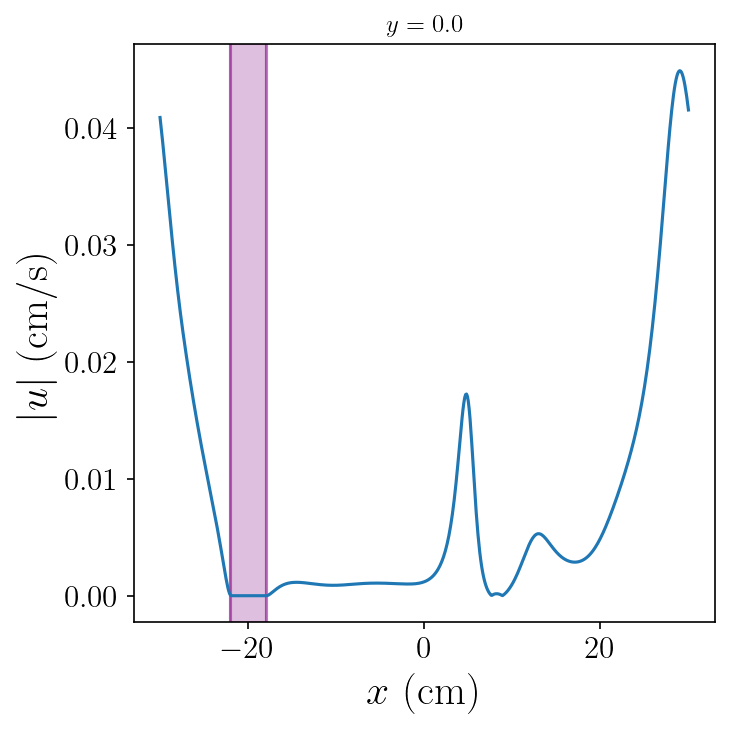

In [19]:
v_x = fluidDf.query("coordinate_y == 0").filter(["coordinate_x", "coordinate_y", "fluidVelocity_x", "fluidVelocity_y"])

fig, ax = plt.subplots(figsize = (5,5))

ax.axvline(-2-20, color = "purple", alpha = 0.5)
ax.axvline(2-20, color = "purple", alpha = 0.5)
ax.axvspan(-2-20, 2-20, color='purple', alpha=0.25)  # Shade the wall

ax.plot(v_x.coordinate_x, np.sqrt(v_x.fluidVelocity_x**2 + v_x.fluidVelocity_y**2), label='LBM') 
ax.set_xlabel("$x$ (cm)")
ax.set_ylabel("$|u|$ (cm/s)")
ax.set_title(f"$y = {v_x.coordinate_y.values[0]}$")
# ax.legend(loc='upper right')

plt.show()

In [20]:
def maxSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).max()

maximumFluidSpeed = [
    maxSpeed(pd.read_csv(dir + f"fluidTrj_{tick}.csv"))
for tick in ticks]
time = [pd.read_csv(dir + f"fluidTrj_{tick}.csv").time.values[0] for tick in ticks]

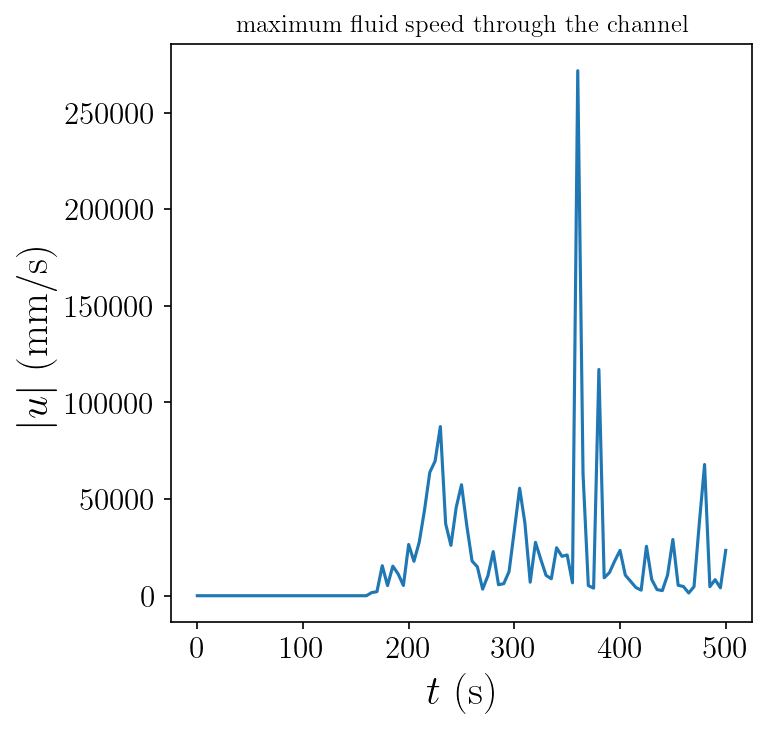

In [21]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, maximumFluidSpeed)
ax.set_title("maximum fluid speed through the channel")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("$|u|$ (mm/s)")

plt.show()

# Tensor de estrés

In [ ]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

stressDf

In [ ]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()